# **Ciclo de potência a vapor de Rankine**

Adaptado de: https://github.com/THE-RAF/Thermodynamics/blob/main/Thermodynamic%20Cycles/rankine_cycle.ipynb

**Diagrama T x S**

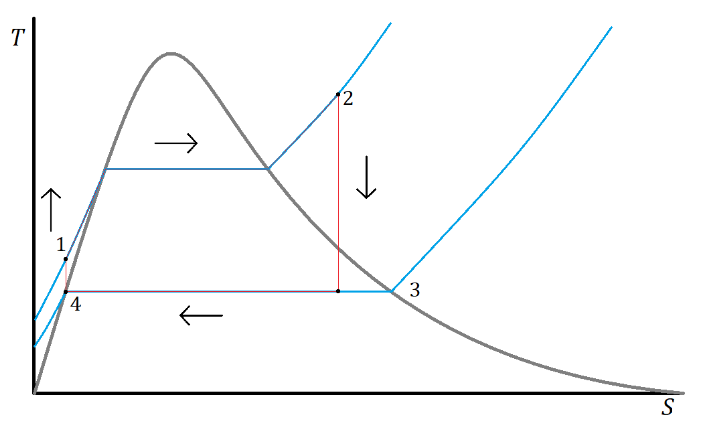

In [ ]:
from math import exp, log as ln
from scipy.integrate import quad

**Funções de conversão para Temperatura**

In [ ]:
def kelvin_to_celsius(K):
    return K - 273.15

def celsius_to_kelvin(C):
    return C + 273.15

def fahrenheit_to_celsius(F):
    return (F - 32) * (5 / 9)

def celsius_to_fahrenheit(C):
    return (C * 9 / 5) + 32

def rankine_to_celsius(R):
    return (R - 491.67) * (5 / 9)

def celsius_to_rankine(C):
    return (C * 9 / 5) + 491.67

def kelvin_to_rankine(K):
    return 1.8 * K

def rankine_to_kelvin(R):
    return (1 / 1.8) * R

def fahrenheit_to_rankine(F):
    return F + 459.67

def rankine_to_fahrenheit(R):
    return R - 459.67

**Funções de conversão para Pressão**

In [ ]:
def bar_to_kpa(bar):
    return 100 * bar

def kpa_to_bar(kpa):
    return 0.01 * kpa

def bar_to_psia(bar):
    return 14.504 * bar

def psia_to_bar(psia):
    return psia / 14.504

def kpa_to_psia(kpa):
    return 0.14504 * kpa

def psia_to_kpa(psia):
    return psia / 0.14504

**Integração numérica**

In [ ]:
def integrate(function, limit_1, limit_2):
    return quad(function, limit_1, limit_2)[0]

**Método da bisecção**

In [ ]:
def bissection(func, target_Y, lower_X, higher_X, tolerance=0.000001, max_iterations=50000):
    lower_Y = func(lower_X)
    higher_Y = func(higher_X)
    print(f'Y interval: [{lower_Y}, {higher_Y}]')

    for i in range(max_iterations):
        center_X = lower_X + (higher_X - lower_X) / 2
        center_Y = func(center_X)

        if center_Y < target_Y:
            lower_X = center_X
        
        if center_Y > target_Y:
            higher_X = center_X
        
        if abs(center_Y - target_Y) <= tolerance:
            break
        
        print('center_X:', center_X, 'center_Y:', center_Y)
    
    else:
        print('the bissection method failed.')
    
    print('resultado final:')
    print('final_X:', center_X, 'final_Y:', center_Y)

    return center_X

**Equação de Antoine para região de saturação**

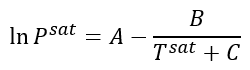

In [ ]:
class Antoine:
	def __init__(self, params):
		self.A = params['A']
		self.B = params['B']
		self.C = params['C']

		self.T_conversion_function = params['T_conversion_function']
		self.P_conversion_function = params['P_conversion_function']
	
	def P_sat(self, T):
		T_converted = self.T_conversion_function['direct'](T)

		A = self.A
		B = self.B
		C = self.C

		P_sat = exp(A - B / (T_converted + C))

		return self.P_conversion_function['reverse'](P_sat)
	
	def T_sat(self, P):
		P_converted = self.P_conversion_function['direct'](P)

		A = self.A
		B = self.B
		C = self.C

		T_sat = B / (A - ln(P_converted)) - C

		return self.T_conversion_function['reverse'](T_sat)

**Capacidade Térmica (Cp)**

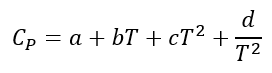

Parâmetros em unidade [ j/mol ]

Para o caso de dados em Cp/R -> multiplicá-los por R

In [ ]:
class Cp:
	def __init__(self, params):
		self.A = params['A']
		self.B = params['B']
		self.C = params['C']
		self.D = params['D']

	def value(self, T):
		A = self.A
		B = self.B
		C = self.C
		D = self.D

		return A + B * T + C * (T**2) + D * (T**-2)

**Equação de Virial truncada no segundo termo**

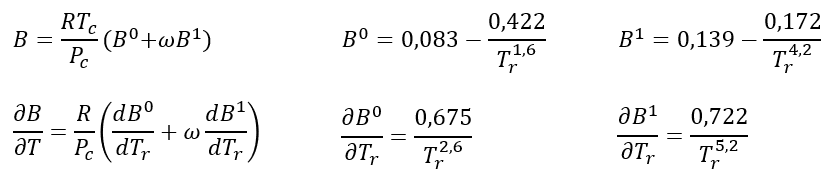

In [ ]:
class Virial:
	@staticmethod
	def B0(Tr):
		return 0.083 - 0.422 / (Tr**(1.6))

	@staticmethod
	def B1(Tr):
		return 0.139 - 0.172 / (Tr**(4.2))

	@staticmethod
	def B(T, Tc, Pc, w, R):
		Tr = T / Tc

		B0 = Virial.B0(Tr)
		B1 = Virial.B1(Tr)

		return (R * Tc / Pc) * (B0 + w * B1)

	@staticmethod
	def dB0_dTr(Tr):
		return 0.675 / (Tr**(2.6))

	@staticmethod
	def dB1_dTr(Tr):
		return 0.722 / (Tr**(5.2))

	@staticmethod
	def dB_dT(T, Tc, Pc, w, R):
		Tr = T / Tc

		dB0_dTr = Virial.dB0_dTr(Tr)
		dB1_dTr = Virial.dB1_dTr(Tr)

		return (R / Pc) * (dB0_dTr + w * dB1_dTr)

**Entalpia:**

In [ ]:
class Enthalpy:
    def __init__(self, fluid_params, system_params, cp):
        self.Cp = cp

        self.Tc = fluid_params['Tc']
        self.Pc = fluid_params['Pc']
        self.w = fluid_params['w']

        self.Tn = system_params['Tn']
        self.Tref = system_params['Tref']
        self.Pref = system_params['Pref']

        self.energy_R = system_params['energy_R']
        self.volume_R = system_params['volume_R']

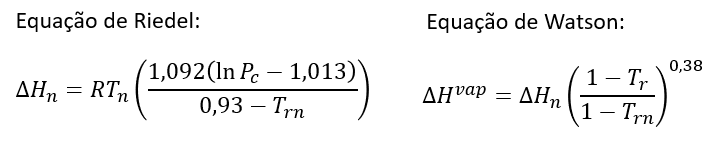

In [ ]:
def delta_H_vap(self, T):
    Tr = T / self.Tc
    Trn = self.Tn / self.Tc

    delta_Hn = self.energy_R * self.Tn * ((1.092 * (ln(self.Pc) - 1.013)) / (0.93 - Trn))
    delta_H_vap = delta_Hn * ((1 - Tr) / (1 - Trn)) ** (0.38)

    return delta_H_vap

setattr(Enthalpy, 'delta_H_vap', delta_H_vap)

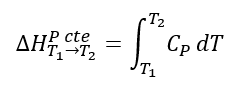

In [ ]:
def delta_H_Pcte(self, T1, T2):
    return integrate(self.Cp.value, T1, T2)

setattr(Enthalpy, 'delta_H_Pcte', delta_H_Pcte)

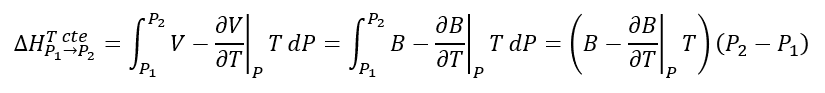

In [ ]:
def delta_H_Tcte(self, T, P1, P2):
    virial_gas_unit_correction = (self.energy_R / self.volume_R)

    B = Virial.B(T, self.Tc, self.Pc, self.w, self.volume_R)
    dB_dT = Virial.dB_dT(T, self.Tc, self.Pc, self.w, self.volume_R)

    return (B - dB_dT * T) * (P2 - P1) * virial_gas_unit_correction

setattr(Enthalpy, 'delta_H_Tcte', delta_H_Tcte)

**Cálculo da entalpia (H) para vapor supersaturado ou saturado:**

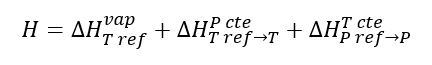

In [ ]:
def H_gas(self, T, P):
    return self.delta_H_vap(self.Tref) + self.delta_H_Pcte(self.Tref, T) + self.delta_H_Tcte(T, self.Pref, P)

setattr(Enthalpy, 'H_gas', H_gas)

**Entropia**

In [ ]:
class Entropy:
    def __init__(self, fluid_params, system_params, cp):
        self.Cp = cp

        self.Tc = fluid_params['Tc']
        self.Pc = fluid_params['Pc']
        self.w = fluid_params['w']

        self.Tref = system_params['Tref']
        self.Pref = system_params['Pref']

        self.energy_R = system_params['energy_R']
        self.volume_R = system_params['volume_R']

        self.delta_H_vap_function = Enthalpy(fluid_params=fluid_params, system_params=system_params, cp=cp).delta_H_vap

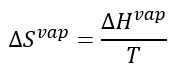

In [ ]:
def delta_S_vap(self, T):
    delta_H_vap = self.delta_H_vap_function(T)

    return delta_H_vap / T

setattr(Entropy, 'delta_S_vap', delta_S_vap)

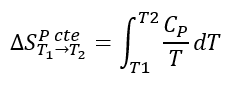

In [ ]:
def delta_S_Pcte(self, T1, T2):
    cp_over_T = lambda T: self.Cp.value(T) / T
    return integrate(cp_over_T, T1, T2)

setattr(Entropy, 'delta_S_Pcte', delta_S_Pcte)

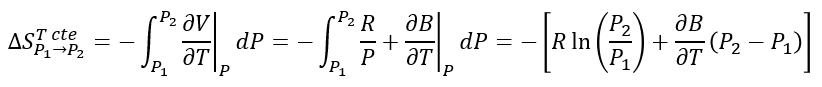

In [ ]:
def delta_S_Tcte(self, T, P1, P2):
    dB_dT = Virial.dB_dT(T, self.Tc, self.Pc, self.w, self.energy_R)

    return -(self.energy_R * ln(P2 / P1) + dB_dT * (P2 - P1))

setattr(Entropy, 'delta_S_Tcte', delta_S_Tcte)

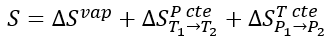

In [ ]:
def S_gas(self, T, P):
    return self.delta_S_vap(self.Tref) + self.delta_S_Pcte(self.Tref, T) + self.delta_S_Tcte(T, self.Pref, P)

setattr(Entropy, 'S_gas', S_gas)

**Volume**

In [ ]:
class Volume:
    def __init__(self, fluid_params, system_params):
        self.Zc = fluid_params['Zc']
        self.Vc = fluid_params['Vc']
        self.Tc = fluid_params['Tc']

        self.energy_R = system_params['energy_R']
        self.volume_R = system_params['volume_R']

**Equação de Rackett**

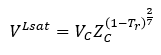

In [ ]:
def sat_liquid_volume(self, T):
    return self.Vc * self.Zc ** ((1-(T / self.Tc)) ** (2/7))

setattr(Volume, 'sat_liquid_volume', sat_liquid_volume)

**Ciclo de potência**

In [ ]:
class Cycle:
    def __init__(self, fluid_params, system_params, cp, antoine):
        self.Cp = cp
        self.Antoine = antoine

        self.T2 = system_params['T2']
        self.P2 = system_params['P2']

        self.P3 = system_params['P3']
        self.Tsat_P3 = self.Antoine.T_sat(self.P3)

        self.n_turb = system_params['n_turb']
        self.n_pump = system_params['n_pump']

        self.energy_R = system_params['energy_R']
        self.volume_R = system_params['volume_R']

        self.fluid_enthalpy = Enthalpy(fluid_params=fluid_params, system_params=system_params, cp=cp)
        self.fluid_entropy = Entropy(fluid_params=fluid_params, system_params=system_params, cp=cp)
        self.fluid_volume = Volume(fluid_params=fluid_params, system_params=system_params)

**Para avaliar o estado do fluido após o resfriamento na turbina**

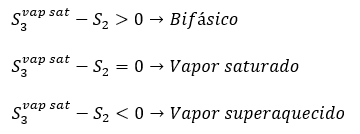

In [ ]:
def S3_vsat_minus_S2(self):
    S2 = self.fluid_entropy.S_gas(self.T2, self.P2)

    T3_vap_sat = self.Antoine.T_sat(self.P3)
    S3_vap_sat = self.fluid_entropy.S_gas(T3_vap_sat, self.P3)

    return S3_vap_sat - S2

def S3_iso_fluid_state(self):
    S3_vsat_minus_S2 = self.S3_vsat_minus_S2()

    fluid_state = 'biphasic' if S3_vsat_minus_S2 > 0 else 'superheated_vapor'

    return fluid_state

setattr(Cycle, 'S3_vsat_minus_S2', S3_vsat_minus_S2)
setattr(Cycle, 'S3_iso_fluid_state', S3_iso_fluid_state)

**Encontrando T3 para o fluido superaquecido isoentrópico**

In [ ]:
def finding_superheated_T3_iso(self):
    S2 = self.fluid_entropy.S_gas(self.T2, self.P2)

    S3_iso_function = lambda T: self.fluid_entropy.S_gas(T, self.P3)
    T3_iso = bissection(func=S3_iso_function, target_Y=S2, lower_X=1, higher_X=10000)

    return T3_iso

setattr(Cycle, 'finding_superheated_T3_iso', finding_superheated_T3_iso)

**Encontrando T3 real para o fluido superaquecido**

In [ ]:
def finding_superheated_real_T3_and_delta_H(self, T3_iso):
    H2 = self.fluid_enthalpy.H_gas(self.T2, self.P2)
    H3_iso = self.fluid_enthalpy.H_gas(T3_iso, self.P3)

    turb_delta_H_iso = H3_iso - H2

    turb_delta_H_real = turb_delta_H_iso * self.n_turb

    delta_H_turb_function = lambda T: self.fluid_enthalpy.H_gas(T, self.P3) - H2

    T3_real = bissection(func=delta_H_turb_function, target_Y=turb_delta_H_real, lower_X=1, higher_X=10000)

    return T3_real, turb_delta_H_real

setattr(Cycle, 'finding_superheated_real_T3_and_delta_H', finding_superheated_real_T3_and_delta_H)

**Encontrando as composições do fluido bifásico isoentrópico**

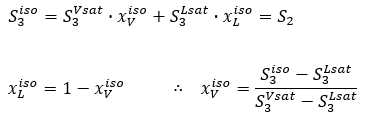

In [ ]:
def isoentropic_compositions(self):
    S3_iso = self.fluid_entropy.S_gas(T=self.T2, P=self.P2)

    S3_vsat = self.fluid_entropy.S_gas(T=self.Tsat_P3, P=self.P3)

    delta_S3_vap = self.fluid_entropy.delta_S_vap(T=self.Tsat_P3)
    S3_lsat = S3_vsat - delta_S3_vap

    X_V_iso = (S3_iso - S3_lsat) / (S3_vsat - S3_lsat)
    X_L_iso = 1 - X_V_iso

    return (X_L_iso, X_V_iso)

setattr(Cycle, 'isoentropic_compositions', isoentropic_compositions)

**Encontrando delta H real da turbina**

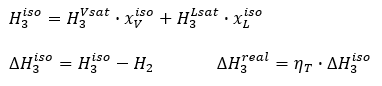

In [ ]:
def real_turbine_delta_H(self, X_L_iso , X_V_iso):
    H3_vsat = self.fluid_enthalpy.H_gas(T=self.Tsat_P3, P=self.P3)
    
    delta_H3_vap = self.fluid_enthalpy.delta_H_vap(T=self.Tsat_P3)
    H3_lsat = H3_vsat - delta_H3_vap

    H3_iso = H3_vsat * X_V_iso + H3_lsat * X_L_iso

    H2 = self.fluid_enthalpy.H_gas(T=self.T2, P=self.P2)

    delta_H3_iso = H3_iso - H2

    delta_H3_real = delta_H3_iso * self.n_turb

    return delta_H3_real

setattr(Cycle, 'real_turbine_delta_H', real_turbine_delta_H)

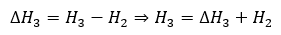

In [ ]:
def H3_real(self, delta_H3_real):
     H2 = self.fluid_enthalpy.H_gas(T=self.T2, P=self.P2)
     H3_real = delta_H3_real + H2

     return H3_real
    
setattr(Cycle, 'H3_real', H3_real)

**Encontrando as composições reais da saída da turbina**

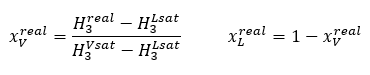

In [ ]:
def real_turbine_compositions(self, delta_H3_real, H3_real):
    H3_vsat = self.fluid_enthalpy.H_gas(T=self.Tsat_P3, P=self.P3)
    
    delta_H3_vap = self.fluid_enthalpy.delta_H_vap(T=self.Tsat_P3)
    H3_lsat = H3_vsat - delta_H3_vap

    X_V_real = (H3_real - H3_lsat) / (H3_vsat - H3_lsat)
    X_L_real = 1 - X_V_real

    return (X_L_real, X_V_real)

setattr(Cycle, 'real_turbine_compositions', real_turbine_compositions)

**Calculando o calor do condensador**

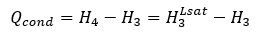

In [ ]:
def cond_heat(self, H3_real):
    H3_vsat = self.fluid_enthalpy.H_gas(T=self.Tsat_P3, P=self.P3)
    
    delta_H3_vap = self.fluid_enthalpy.delta_H_vap(T=self.Tsat_P3)
    H3_lsat = H3_vsat - delta_H3_vap

    Q_cond = H3_lsat - H3_real

    return Q_cond

setattr(Cycle, 'cond_heat', cond_heat)

**Calculando o trabalho realizado pela bomba**

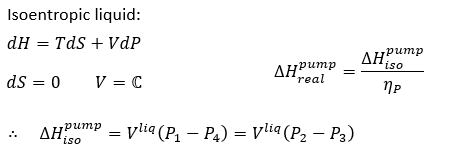

In [ ]:
def pump_work(self):
    virial_gas_unit_correction = (self.energy_R / self.volume_R)

    V_liq_sat = self.fluid_volume.sat_liquid_volume(self.Tsat_P3)
    delta_H_pump_iso = V_liq_sat * (self.P2 - self.P3)

    delta_H_pump_real = (delta_H_pump_iso / self.n_pump) * virial_gas_unit_correction

    return delta_H_pump_real

setattr(Cycle, 'pump_work', pump_work)

**Calculando o calor fornecido pela caldeira**

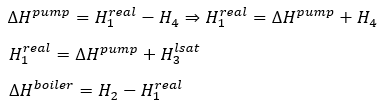

In [ ]:
def boiler_heat(self, pump_work):
    H3_vsat = self.fluid_enthalpy.H_gas(T=self.Tsat_P3, P=self.P3)
    
    delta_H3_vap = self.fluid_enthalpy.delta_H_vap(T=self.Tsat_P3)
    H3_lsat = H3_vsat - delta_H3_vap

    H1_real = pump_work + H3_lsat

    H2 = self.fluid_enthalpy.H_gas(T=self.T2, P=self.P2)

    delta_H_boiler = H2 - H1_real

    return delta_H_boiler

setattr(Cycle, 'boiler_heat', boiler_heat)

**Eficiência do ciclo**

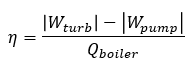

In [ ]:
def cycle_efficiency(self, W_turb, W_pump, Q_boiler):
    return (abs(W_turb) - abs(W_pump)) / Q_boiler

setattr(Cycle, 'cycle_efficiency', cycle_efficiency)

In [ ]:
def full_cycle(self):
    S3_iso_fluid_state = self.S3_iso_fluid_state()
    print('Fluid state after turbine:', S3_iso_fluid_state)
    print()

    if S3_iso_fluid_state == 'superheated_vapor':
        print('finding superheated vapor T3_iso:')
        print()
        T3_iso = self.finding_superheated_T3_iso()
        print()
        print('T3_iso:', T3_iso)
        print()

        print('finding superheated vapor T3_real:')
        print()
        T3, delta_H_turb_real = self.finding_superheated_real_T3_and_delta_H(T3_iso)
        print()
        print('T3_real:', T3)
        print('delta_H_turb_real:', delta_H_turb_real)
        print()

        H3_real = self.H3_real(delta_H_turb_real)
        print('H3_real:', H3_real)
        print()


    if S3_iso_fluid_state == 'biphasic':
        T3 = self.Antoine.T_sat(self.P3)
        print('T3_real:', T3)
        print()

        X_L_iso , X_V_iso = self.isoentropic_compositions()
        print('X_Liq_iso:', X_L_iso)
        print('X_Vap_iso:', X_V_iso)
        print()

        delta_H_turb_real = self.real_turbine_delta_H(X_L_iso , X_V_iso)
        print('real turbine delta H:', delta_H_turb_real)
        print()

        H3_real = self.H3_real(delta_H_turb_real)
        print('H3_real:', H3_real)
        print()

        X_L_real , X_V_real = self.real_turbine_compositions(delta_H_turb_real, H3_real)
        print('X_Liq_real:', X_L_real)
        print('X_Vap_real:', X_V_real)
        print()

    print('Turbine work:', delta_H_turb_real)
    print()

    Q_cond = self.cond_heat(H3_real)
    print('Cond heat:', Q_cond)
    print()

    pump_work = self.pump_work()
    print('Pump work:', pump_work)
    print()

    Q_boiler = self.boiler_heat(pump_work)
    print('Boiler heat:', Q_boiler)
    print()

    cycle_efficiency = self.cycle_efficiency(W_turb=delta_H_turb_real, W_pump=pump_work, Q_boiler=Q_boiler)
    print('Cycle efficiency:', cycle_efficiency)

setattr(Cycle, 'full_cycle', full_cycle)

**Exercício 7**

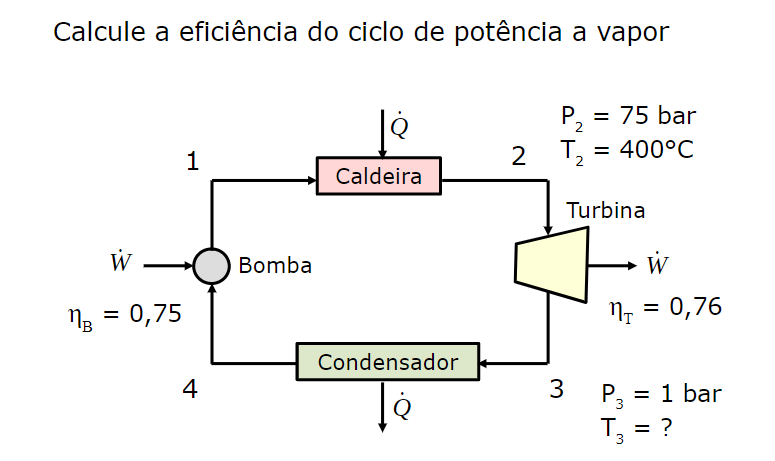

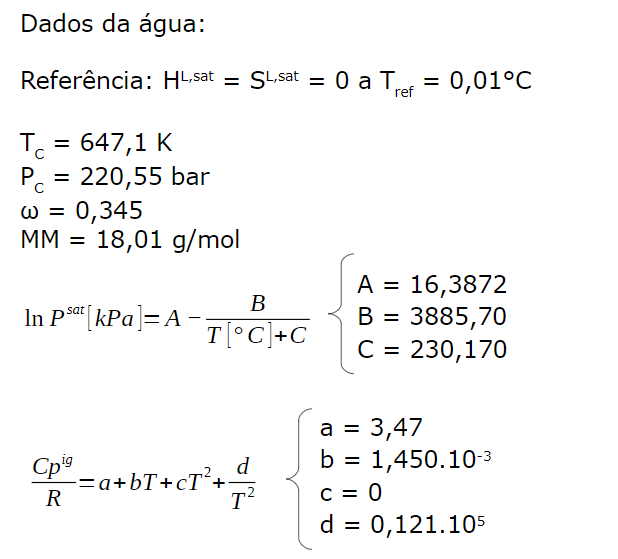

In [ ]:
system_params = {
    'Tn': 373.15,
    'Tref': 273.16,
    'Pref': 0.006102,
    'T2': 520 + 273.15,
    'P2': 85,
    'P3': 0.1,
    'n_turb': 0.75,
    'n_pump': 0.75,
    'energy_R': 8.314,
    'volume_R': 83.14
}

antoine_params = {
	'A': 16.3872,
	'B': 3885.7,
	'C': 230.17,
	'T_conversion_function': {'direct': kelvin_to_celsius, 'reverse': celsius_to_kelvin},
	'P_conversion_function': {'direct': bar_to_kpa, 'reverse': kpa_to_bar},
}

cp_params = {
    'A': 3.47,
    'B': 1.45*(10**-3),
    'C': 0,
    'D': 0.121*(10**5)
}

'''multiplicando os parâmetros de Cp por R pois o Cp foi dado em Cp/R'''
for param in cp_params: cp_params[param] *= system_params['energy_R']

fluid_params = {
    'Tc': 647.1,
    'Pc': 220.55,
    'Zc': 0.229,
    'Vc': 55.9,
    'w':  0.345,
    'MM': 18.01,
}



In [ ]:
cp = Cp(cp_params)
antoine = Antoine(antoine_params)

cycle = Cycle(fluid_params=fluid_params, system_params=system_params, cp=cp, antoine=antoine)
cycle.full_cycle()

Fluid state after turbine: biphasic

T3_real: 318.8625871815053

X_Liq_iso: 0.1782258682716934
X_Vap_iso: 0.8217741317283066

real turbine delta H: -17588.65855273936

H3_real: 46651.74897257832

X_Liq_real: 0.047974981562750485
X_Vap_real: 0.9520250184372495

Turbine work: -17588.65855273936

Cond heat: -42852.79331821618

Pump work: 187.90834443061186

Boiler heat: 60253.54352652493

Cycle efficiency: 0.28879214714813506
